<a href="https://colab.research.google.com/github/emmanuellaanggi/disaster_tweet_sentiment/blob/master/(Medium)_Text_Classification_Disaster_Tweet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Data from kaggle**

First, the data. first things first is installing kaggle to my environment i dont have to download the data to my drive/local. It's super efficient.

To get the API, go to your kaggle profile and download the JSON file!

In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

download the dataset directly by copying the API command on the dataset page

In [ ]:
! kaggle competitions download -c nlp-getting-started

#**Downloading pre-trained fastText, preparing datasets, and pre-processing**

In [17]:
import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [1]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer 
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



Converting all the words to index in number, to the embedding index in pre-trained model and converted all the missing words to 0,

In [27]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

957it [00:00, 9561.73it/s]

loading word embeddings...


1999996it [03:28, 9609.17it/s]

found 1999996 word vectors


Read both the train data and test data

In [28]:
from sklearn.model_selection import train_test_split
#load data
data = pd.read_csv('train.csv', sep=',', header=0)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
test_data.to_csv("test_dat.csv")
train_data.to_csv("train_dat.csv")

train_df = pd.read_csv('train_dat.csv', sep=',', header=0)
test_df = pd.read_csv('test_dat.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("Number of training data ", train_df.shape[0])
print("Number of testing data: ", test_df.shape[0])

Number of training data  6090
Number of testing data:  1523


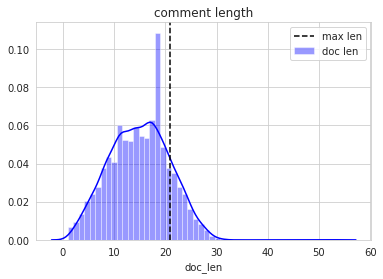

In [29]:
label_names = ["target"]
y_train = train_df[label_names].values
train_df['doc_len'] = train_df['text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

tokenizing the data with tokenizer from tensorflow

In [30]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  7%|▋         | 416/6090 [00:00<00:01, 4158.94it/s]

pre-processing train data...


100%|██████████| 1523/1523 [00:00<00:00, 4567.71it/s]


tokenizing input data...
dictionary size:  22258


#**Shape and Train with LSTM**

defining variables that used on training

In [31]:
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

building the embedding matrix for the weights in Embedding Layer on training. more about embedding matrix: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

all words that aren't in the pre-trained model from fasttext would be changed to 0. the words are basically the ones with typos or names, the words mostly dont matter so much to the pattern. so it's nicer to just weights it 0.

In [32]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 9175


In [33]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['cfe9huqn0h' 'hereticofethics' '93infxzhx0' '15000270653' 'd50orfxofb'
 'splatling' 'littlebitofbass' 'keepingtheviginaclean' 'lzob8qoh1b'
 'canagal']


let's start training! here are the layers. i have been doing some test and modification on using the layer, unit cells, etc. and so far it works the best for me. tell me i

In [34]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 300)           6677700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,765,061
Trainable params: 87,361
Non-trainable params: 6,677,700
_________________________________________________________________


In [35]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
17/17 [==============================] - 2s 137ms/step - loss: 0.6530 - accuracy: 0.6409 - val_loss: 0.5940 - val_accuracy: 0.7269
Epoch 2/40
17/17 [==============================] - 2s 90ms/step - loss: 0.5173 - accuracy: 0.7823 - val_loss: 0.4821 - val_accuracy: 0.7739
Epoch 3/40
17/17 [==============================] - 1s 88ms/step - loss: 0.4450 - accuracy: 0.8105 - val_loss: 0.4577 - val_accuracy: 0.7986
Epoch 4/40
17/17 [==============================] - 2s 89ms/step - loss: 0.4106 - accuracy: 0.8311 - val_loss: 0.4556 - val_accuracy: 0.7991
Epoch 5/40
17/17 [==============================] - 2s 89ms/step - loss: 0.3904 - accuracy: 0.8442 - val_loss: 0.4574 - val_accuracy: 0.8041
Epoch 6/40
17/17 [==============================] - 2s 90ms/step - loss: 0.3755 - accuracy: 0.8510 - val_loss: 0.4573 - val_accuracy: 0.8035
Epoch 7/40
17/17 [==============================] - 2s 90ms/step - loss: 0.3580 - accuracy: 0.8614 - val_loss: 0.4632 - val_accuracy: 0.8046


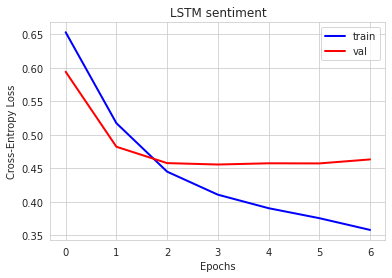

In [37]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

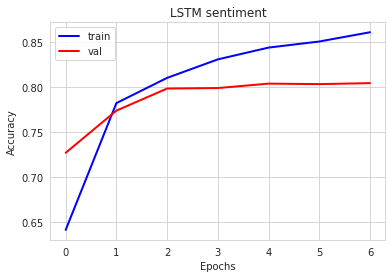

In [38]:
plt.figure()
plt.plot(history.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [ ]:
predictions = model.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)
sample[['pred', "target"]]

In [40]:
import sklearn

print("Accuracy With fastText :")
print(sklearn.metrics.accuracy_score(sample.target, sample.pred))

Accuracy With fastText :
0.8312541037426132


In [41]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

it's **80%**! not so good but also not that bad, huh?

# **LET'S COMPARE WITH GLOVE!**

In [88]:
import requests, zipfile, io
zip_file_url = "http://nlp.stanford.edu/data/glove.840B.300d.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [42]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/glove.840B.300d.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

827it [00:00, 8264.86it/s]

loading word embeddings...


2196018it [04:19, 8451.82it/s]

found 2196016 word vectors


In [43]:
from sklearn.utils import shuffle 

raw_docs_train = train_df['text'].tolist()
raw_docs_test = test_df['text'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

  7%|▋         | 435/6090 [00:00<00:01, 4343.04it/s]

pre-processing train data...


100%|██████████| 1523/1523 [00:00<00:00, 4688.38it/s]


tokenizing input data...
dictionary size:  22258


In [44]:
from keras.layers import BatchNormalization
import tensorflow as tf

model_glove = tf.keras.Sequential()

model_glove.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model_glove.add(Bidirectional(LSTM(32)))
model_glove.add(Dense(32,activation='relu'))
model_glove.add(Dropout(0.4))
model_glove.add(Dense(1,activation='sigmoid'))
model_glove.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 21, 300)           6677700   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                85248     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,765,061
Trainable params: 87,361
Non-trainable params: 6,677,700
_________________________________________________________________


In [45]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = model_glove.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
17/17 [==============================] - 3s 166ms/step - loss: 0.6428 - accuracy: 0.6617 - val_loss: 0.5791 - val_accuracy: 0.7542
Epoch 2/40
17/17 [==============================] - 2s 89ms/step - loss: 0.5071 - accuracy: 0.7851 - val_loss: 0.4731 - val_accuracy: 0.7811
Epoch 3/40
17/17 [==============================] - 2s 90ms/step - loss: 0.4356 - accuracy: 0.8130 - val_loss: 0.4511 - val_accuracy: 0.7991
Epoch 4/40
17/17 [==============================] - 2s 89ms/step - loss: 0.4029 - accuracy: 0.8360 - val_loss: 0.4488 - val_accuracy: 0.8057
Epoch 5/40
17/17 [==============================] - 2s 89ms/step - loss: 0.3932 - accuracy: 0.8431 - val_loss: 0.4457 - val_accuracy: 0.8019
Epoch 6/40
17/17 [==============================] - 2s 89ms/step - loss: 0.3731 - accuracy: 0.8541 - val_loss: 0.4529 - val_accuracy: 0.8024
Epoch 7/40
17/17 [==============================] - 2s 89ms/step - loss: 0.3607 - accuracy: 0.8578 - val_loss: 0.4578 - val_accuracy: 0.8041
Epoch 8/40
1

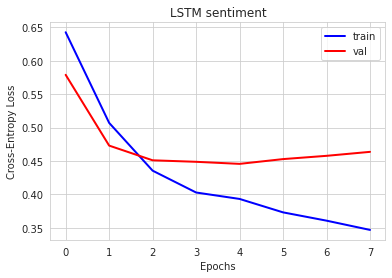

In [47]:
#generate plots
plt.figure()
plt.plot(history_glove.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

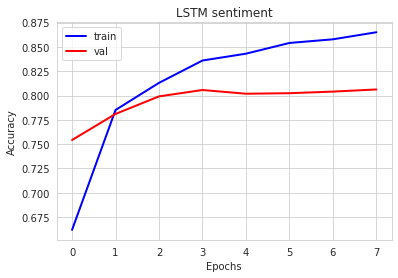

In [48]:
plt.figure()
plt.plot(history_glove.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(history_glove.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

In [49]:
predictions = model_glove.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)

In [50]:
import sklearn
print("Accuracy With GloVe :")
print(sklearn.metrics.accuracy_score(sample.target, sample.pred))

Accuracy With GloVe :
0.8207485226526592


In [51]:
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

# **COMPARE WITHOUT WORD EMBEDDING**

In [57]:
from keras.layers import BatchNormalization
import tensorflow as tf

without_mod = tf.keras.Sequential()

without_mod.add(Embedding(nb_words,embed_dim,input_length=max_seq_len,trainable=False))
without_mod.add(Bidirectional(LSTM(32)))
without_mod.add(Dense(32,activation='relu'))
without_mod.add(Dropout(0.4))
without_mod.add(Dense(1,activation='sigmoid'))
without_mod.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 300)           6677700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                85248     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 6,765,061
Trainable params: 87,361
Non-trainable params: 6,677,700
_________________________________________________________________


In [58]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

without_mod.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history_glove = without_mod.fit(word_seq_train, y_train, batch_size=256,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
17/17 [==============================] - 2s 131ms/step - loss: 0.6820 - accuracy: 0.5567 - val_loss: 0.6686 - val_accuracy: 0.5545
Epoch 2/40
17/17 [==============================] - 2s 89ms/step - loss: 0.6619 - accuracy: 0.5855 - val_loss: 0.6483 - val_accuracy: 0.6218
Epoch 3/40
17/17 [==============================] - 1s 88ms/step - loss: 0.6551 - accuracy: 0.6127 - val_loss: 0.6434 - val_accuracy: 0.6382
Epoch 4/40
17/17 [==============================] - 2s 88ms/step - loss: 0.6440 - accuracy: 0.6284 - val_loss: 0.6375 - val_accuracy: 0.6360
Epoch 5/40
17/17 [==============================] - 1s 88ms/step - loss: 0.6415 - accuracy: 0.6434 - val_loss: 0.6377 - val_accuracy: 0.6333
Epoch 6/40
17/17 [==============================] - 2s 89ms/step - loss: 0.6322 - accuracy: 0.6451 - val_loss: 0.6264 - val_accuracy: 0.6426
Epoch 7/40
17/17 [==============================] - 2s 89ms/step - loss: 0.6201 - accuracy: 0.6608 - val_loss: 0.6172 - val_accuracy: 0.6552
Epoch 8/40
1

In [60]:
predictions = without_mod.predict_classes(word_seq_test)
sample=pd.read_csv('test_dat.csv')
sample['pred']= (predictions>0.5).astype(int)

In [61]:
import sklearn
print("Accuracy With GloVe :")
print(sklearn.metrics.accuracy_score(sample.target, sample.pred))

Accuracy With GloVe :
0.6966513460275772
